# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import ast
import random

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from configparser import ConfigParser

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive
#### 1. First mount

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/sound-of-failure


#### 2. Remount

In [3]:
%cd ../../..
drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/sound-of-failure

/
Mounted at /gdrive
/gdrive/My Drive/sound-of-failure


# Import Own Modules

In [4]:
sys.path += ['src/01_data_processing', 'src/02_modelling']

import spectrogram as spec
import train_test_split as splt
from conv_autoencoder import ConvAutoencoder

hello world
/gdrive/My Drive/sound-of-failure


# Global constants

### First run the scripts for building the config files.

Some of the parameters can be passed through the command line.
At present the command line parameters are the following :

1. conf_base.py : Script for building the base config file (saves in sound-of-failure/conf/conf_base.ini)
        -raw : Pass the location of the raw data dir


2. conf_convAE.py : Script for building the config file holding the parameters for Mel Spectrogram and Convolutional Autoencoder (saves in sound-of-failure/conf/conf_convAE.ini)
        -mel : No. of mels
        -fft : No. of FFT bands
        -hop : Hop length for the sliding window while calculating FFT
        -dim : Time dimension of one spectrogram block after chunking the whole spectrogram
        -s : Step for the sliding window for creating chunks from one spectrogram


To check the description of the command line parameters one could activate the '-h' flag. For example :

In [5]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_convAE.py -h

usage: make_conf_convAE.py [-h] [-mel] [-fft] [-hop] [-dim] [-s]

Params for Spectrogram and Conv AE

optional arguments:
  -h, --help            show this help message and exit
  -mel , --n_mels       No. of mel bands
  -fft , --n_fft        No. of FFT bands
  -hop , --hop_length   Hop length for FFT calc
  -dim , --dim          Time dimension of Spectrogram block
  -s , --step           Sliding window step for Spectrogram chunking


In [6]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_base.py -raw '/gdrive/MyDrive/Hitachi_data/dataset'
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_convAE.py -mel 128 -fft 1024 -hop 512 -dim 32 -s 8

### Then read from the config files

There are two config files : 

1. sound-of-failure/conf/**conf_base**.ini
2. sound-of-failure/conf/**conf_convAE**.ini

In [7]:
def read_config(config_file):
  """
  Function for reading config files
  """
  config = ConfigParser()
  config.read(config_file)
  return config

In [8]:
base_conf = read_config('/gdrive/MyDrive/sound-of-failure/conf/conf_base.ini')
param_conf = read_config('/gdrive/MyDrive/sound-of-failure/conf/conf_convAE.ini')

#### Read the parameters directly from the config files

Question : Should the reading of config files be done within notebooks or the source script should directly read from them?

In [9]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
               param_conf.getint('melspec', 'n_mels'),
               1)

LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Execute preprocessing steps
#### 1. Generate unscaled mel spectrograms (~ 5 minutes)

In [10]:
spec.make_mel_dirs(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)

spec.make_mels(RAW_DATA_DIR, BASE_DIR, 
               DB, MACHINE_TYPE, MACHINE_ID, 
               N_MELS, N_FFT, HOP_LENGTH, POWER, WINDOW)

Generate normal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal.
Generate abnormal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal.


#### 2. Separate train and test files

In [11]:
train_files, train_labels, test_files, test_labels = splt.make_train_test_split(BASE_DIR, 
                                                                           DB, MACHINE_TYPE, MACHINE_ID, 
                                                                           random_seed=1)

#### 3. Fit scaler to train files

#### 3.1 Plot an example spectrogram

Just a sanity check

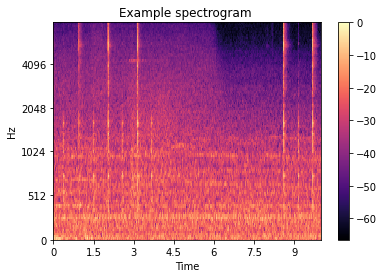

In [12]:
spect = np.load('/gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal/00000990.npy')

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

In [13]:
scaler = spec.create_scaler(SCALER_TYPE)
spec.fit_scaler_to_mel_files(scaler, train_files)

#### 4. Generate training data from scaling and subsampling mel spectrograms

In [14]:
train_data = splt.generate_train_data(train_files, scaler, DIM, STEP)

In [15]:
train_data.shape

(32264, 32, 128, 1)

# Modelling

### Build Convolutional Autoencoder

In [16]:
my_model = ConvAutoencoder(input_shape=INPUT_SHAPE,
                           num_nodes=NUM_NODES,
                           num_kernel=NUM_KERNEL,
                           num_strides=NUM_STRIDES,
                           latent_dim=LATENT_DIM)

print(my_model.summary())

This is my autoencoder
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, 32, 128, 1)]      0         
_________________________________________________________________
Conv_enc0 (Conv2D)           (None, 32, 64, 32)        832       
_________________________________________________________________
BatchNorm_enc0 (BatchNormali (None, 32, 64, 32)        128       
_________________________________________________________________
ReLU_enc0 (ReLU)             (None, 32, 64, 32)        0         
_________________________________________________________________
Conv_enc1 (Conv2D)           (None, 16, 32, 64)        51264     
_________________________________________________________________
BatchNorm_enc1 (BatchNormali (None, 16, 32, 64)        256       
_________________________________________________________________
ReLU_enc1 (ReLU)             (None, 

Epoch 1/30
454/454 [==============================] - 47s 31ms/step - loss: 0.2479 - val_loss: 0.1094
Epoch 2/30
454/454 [==============================] - 13s 29ms/step - loss: 0.0924 - val_loss: 0.0927
Epoch 3/30
454/454 [==============================] - 13s 29ms/step - loss: 0.0769 - val_loss: 0.0907
Epoch 4/30
454/454 [==============================] - 13s 29ms/step - loss: 0.0733 - val_loss: 0.0746
Epoch 5/30
454/454 [==============================] - 13s 30ms/step - loss: 0.0717 - val_loss: 0.0756
Epoch 6/30
454/454 [==============================] - 14s 30ms/step - loss: 0.0698 - val_loss: 0.0872
Epoch 7/30
454/454 [==============================] - 14s 30ms/step - loss: 0.0697 - val_loss: 0.0786
Epoch 8/30
454/454 [==============================] - 14s 30ms/step - loss: 0.0694 - val_loss: 0.0857
Epoch 9/30
454/454 [==============================] - 14s 30ms/step - loss: 0.0682 - val_loss: 0.0709
Epoch 10/30
454/454 [==============================] - 14s 30ms/step - loss: 0.068

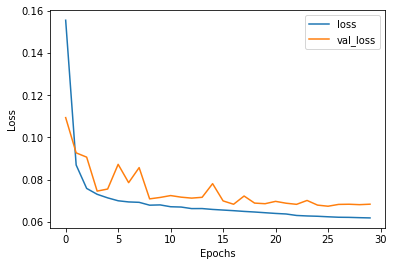

In [17]:
model = my_model.model

model.compile(loss=LOSS, optimizer=OPTIMIZER)

history = model.fit(train_data,
                    train_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=VALIDATION_SPLIT,
                    shuffle=SHUFFLE,
                    verbose=1)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.close()

# Evaluation : Reconstruction error and ROC AUC score

In [18]:
y_pred = np.zeros(len(test_files))
y_true = test_labels

for idx, test_file in tqdm.tqdm(enumerate(test_files), total=len(test_files)):
  #print("File no.={}, location={}, label={}".format(idx, test_file, test_label))

  mel = np.load(test_file)

  scaled_mel = spec.apply_scaler_to_mel(scaler, mel)

  batch = splt.subsample_from_mel(scaled_mel, DIM, STEP)

  batch_prediction = model.predict(batch)

  squared_error = np.square(batch - batch_prediction)
  channelwise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(channelwise_error)

  y_pred[idx] = reconstruction_error


auc_score = metrics.roc_auc_score(y_true, y_pred)
print("Roc AUC score={}".format(auc_score))

100%|██████████| 238/238 [00:11<00:00, 20.77it/s]

Roc AUC score=0.8894145893651577
